In [20]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from path_generator import *
from model_pricing import *
from flags import FLAGS
tf.__version__

from datetime import datetime

logdir = "./logs/" + "mse_loss_1e4"+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
BATCH_SIZE = 500
BUFFER_SIZE = 100
FLAGS.SAMPLES = int(10000)
n_assets = 2 #rf rate and stock

In [22]:
#train
train_paths,train_labels,time_grid = BS_Generator(n_paths=10000)

T = len(time_grid)

dsc = np.tile(discount_factor(time_grid),(FLAGS.SAMPLES,1))

train_labels = np.append(np.append(dsc,train_paths,axis=-1),train_labels.reshape(-1,1),axis=-1)[:,:,np.newaxis]

train_paths = train_paths[:,:,np.newaxis]
dsc = dsc[:,:,np.newaxis]
train_paths = np.append(dsc,train_paths,axis=-1)

# test
test_paths,test_labels,time_grid = BS_Generator(n_paths=FLAGS.SMALL_SAMPLE)

dsc = np.tile(discount_factor(time_grid),(FLAGS.SMALL_SAMPLE,1))

test_labels = np.append(np.append(dsc,test_paths,axis=-1),test_labels.reshape(-1,1),axis=-1)[:,:,np.newaxis]

test_paths = test_paths[:,:,np.newaxis]
dsc = dsc[:,:,np.newaxis]
test_paths = np.append(dsc,test_paths,axis=-1)


print('feature set: ',train_paths.shape) #samples,times,n_assets
print('target set: ',train_labels.shape) #samples,times*n_assets+1,1

feature set:  (10000, 30, 2)
target set:  (10000, 61, 1)


In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths,test_labels))
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_ds = test_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [24]:
def generate_model():

    class RNNCell(tf.keras.layers.Layer):

        def __init__(self, units, output_size, **kwargs):
            self.units = units
            self.state_size = output_size
            super(RNNCell, self).__init__(**kwargs)

        def build(self, input_shape):

            self.Wh = self.add_weight(shape=(self.state_size, self.units),
                                          initializer='uniform',
                                          name='Wh')

            self.W1 = self.add_weight(shape=(input_shape[-1], self.units),
                                          initializer='uniform',
                                          name='W1')

            self.b1 = self.add_weight(shape=(self.units,),
                                          initializer='uniform',
                                          name='b1')

            self.W2 = self.add_weight(shape=(self.units, self.units),
                                          initializer='uniform',
                                          name='W2')

            self.b2 = self.add_weight(shape=(self.units,),
                                          initializer='uniform',
                                          name='b2')

            self.W3 = self.add_weight(shape=(self.units, self.state_size-1),
                                          initializer='uniform',
                                          name='W3')

            self.b3 = self.add_weight(shape=(1, self.state_size-1),
                                          initializer='uniform',
                                          name='b3')

            self.built = True

        def call(self, inputs, states):

            prev_output = states[0]
            
            output = tf.keras.backend.dot(inputs, self.W1) + self.b1
            output = tf.keras.activations.sigmoid(output + tf.keras.backend.dot(prev_output, self.Wh))
            
            output = tf.keras.activations.sigmoid(tf.keras.backend.dot(output,self.W2) + self.b2)
            output = tf.keras.activations.sigmoid(tf.keras.backend.dot(output,self.W3) + self.b3)
               
            pft_value = tf.reduce_sum(tf.multiply( inputs, prev_output ),1,keepdims=True)
            
            rf_asset = (pft_value-tf.reduce_sum(tf.multiply( inputs[:,1:], output ),1,keepdims=True))/inputs[:,0:1]
            
            output = tf.concat([rf_asset,output],axis=1)
            
            return output, [output]


    cell = RNNCell(units=30, output_size=n_assets)
    
    layer = tf.keras.layers.RNN(cell, input_shape=(30,2), return_sequences=True)
    

    model = tf.keras.Sequential()
    model.add(layer)

    return model

model = generate_model()

In [25]:
x = tf.random.normal([17,30,n_assets])

y = model(x)

y.shape

TensorShape([17, 30, 2])

In [26]:
def portfolio_value(y_true, y_pred):
    assets = tf.split(y_true[:,:2*T,:], n_assets, axis=1)
    option = y_true[:,-1:,0]
    
    portfolio = 0
    for i,a in enumerate(assets):
            portfolio += a[:,-1,:]*y_pred[:,-1,i:i+1]
            
    return portfolio

def loss_mse(y_true, y_pred):
    
    option = y_true[:,-1:,0]
    
    portfolio = portfolio_value(y_true, y_pred)
    
    return tf.keras.losses.mse(option, portfolio)

def loss_entropy(y_true, y_pred):
    
    option = y_true[:,-1:,0]
    
    portfolio = portfolio_value(y_true, y_pred)
    
    return tf.keras.losses.binary_crossentropy(option, portfolio, from_logits=True)

def loss_oce(y_true, y_pred):
    
    l = 1
    
    option = y_true[:,-1:,0]
    
    portfolio = portfolio_value(y_true, y_pred)
    
    return 1/l*tf.keras.backend.log(tf.reduce_mean(tf.keras.backend.exp(-l*(-option+portfolio)),axis=-1))

def loss_mae(y_true, y_pred):
    
    option = y_true[:,-1:,0]
    
    portfolio = portfolio_value(y_true, y_pred)
    
    return tf.keras.losses.mae(option, portfolio)

def loss_var(y_true, y_pred):
    
    a = 0.99
    
    option = y_true[:,-1:,0]
    
    portfolio = portfolio_value(y_true, y_pred)
    
    e = option-portfolio
    
    q = a
    
    return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

opt = tf.keras.optimizers.Adam(0.005)

model.compile(optimizer=opt, loss=loss_mse)

In [36]:
for x,y in train_ds.take(1):
    print("y_shape: ", y.shape)
    print("x_shape: ", x.shape)
    print("out_shape: ", model.predict(x).shape)
    print(loss_mse(y, model.predict(x)).shape)
    print(loss_oce(y, model.predict(x)).shape)
    print(loss_var(y, model.predict(x)).shape)

y_shape:  (500, 61, 1)
x_shape:  (500, 30, 2)
out_shape:  (500, 30, 2)
(500,)
(500,)
()


In [28]:
EPOCHS = 1
initial_epoch = 0
EVALUATION_INTERVAL = FLAGS.SAMPLES/10
model.fit(train_ds, epochs=EPOCHS, initial_epoch=initial_epoch,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=test_ds, validation_steps=100,
                    callbacks=[tensorboard_callback])
initial_epoch = EPOCHS

Train for 1000.0 steps, validate for 100 steps
1000/1000 [==============================] - 37s 37ms/step - loss: 2.3440 - val_loss: 1.9185


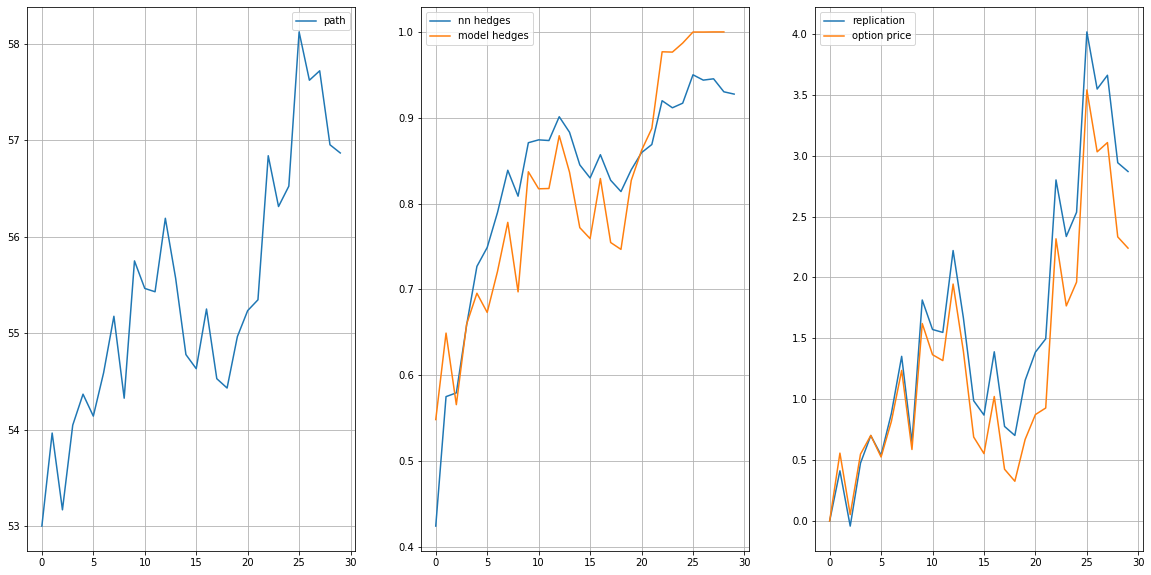

BS price:  1.628
loss:  tf.Tensor(1.3089772664090458, shape=(), dtype=float64)


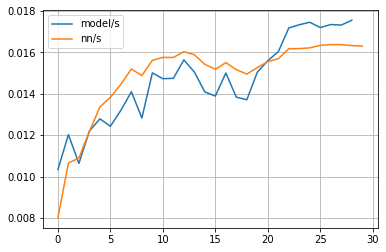

##############################################################################################################


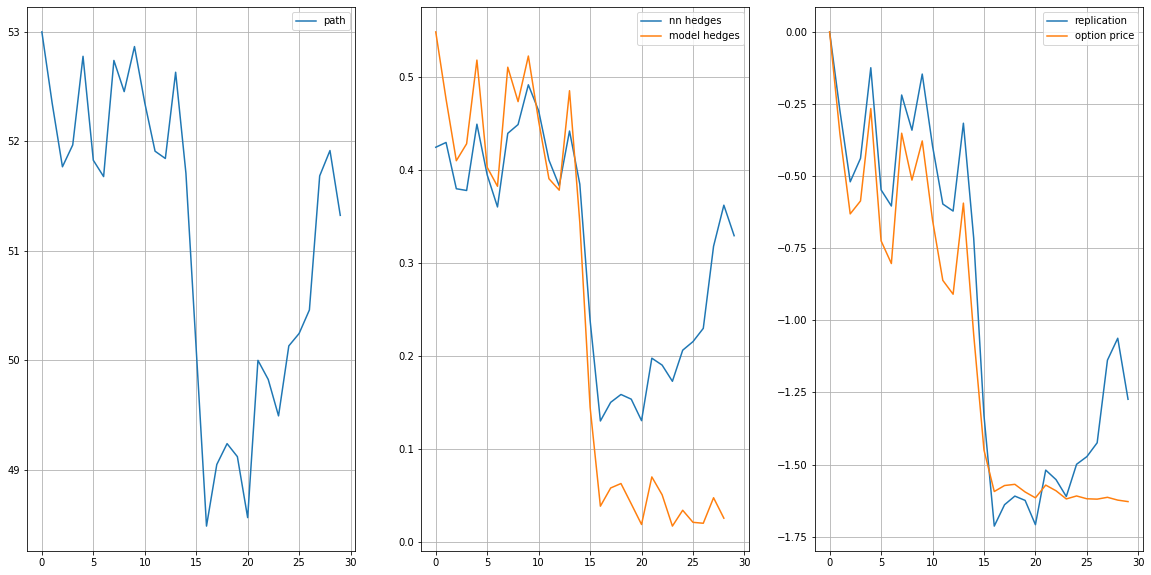

BS price:  1.628
loss:  tf.Tensor(1.3089773385201897, shape=(), dtype=float64)


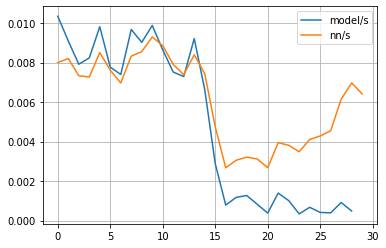

##############################################################################################################


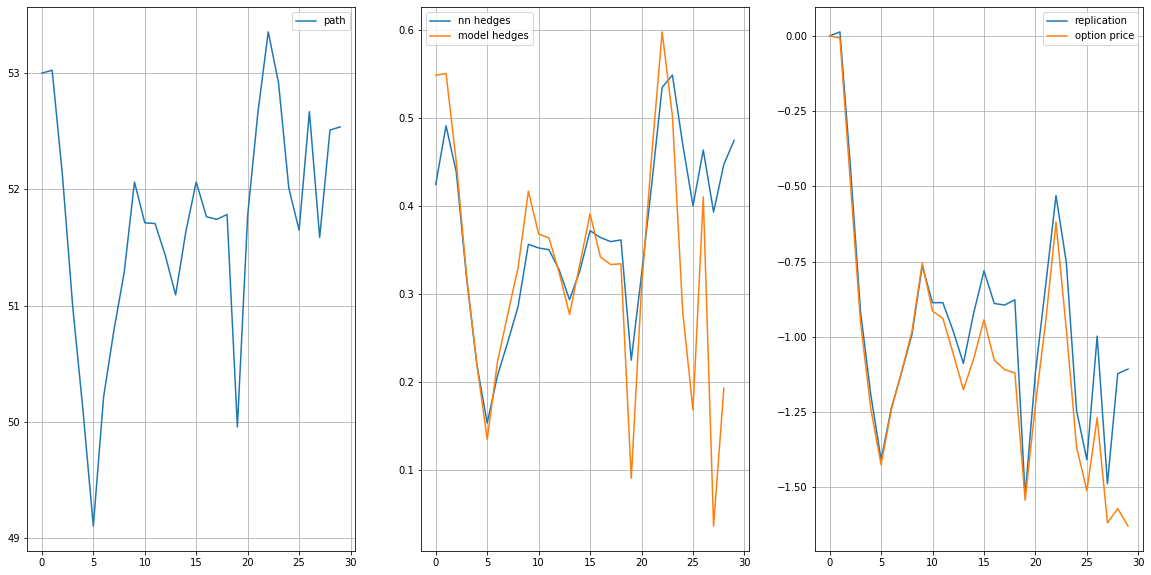

BS price:  1.628
loss:  tf.Tensor(1.3089773400112084, shape=(), dtype=float64)


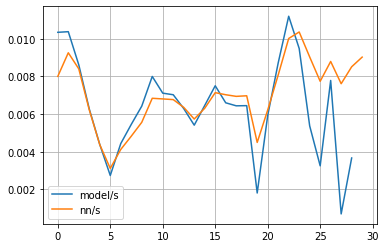

##############################################################################################################


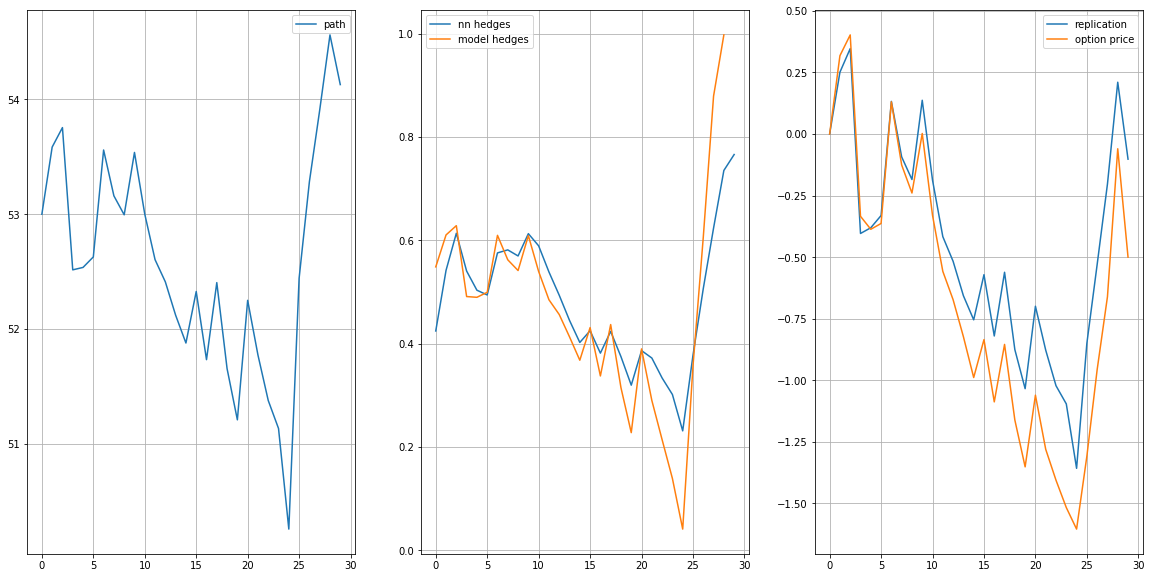

BS price:  1.628
loss:  tf.Tensor(1.3089773412029726, shape=(), dtype=float64)


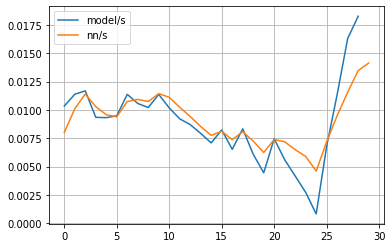

##############################################################################################################


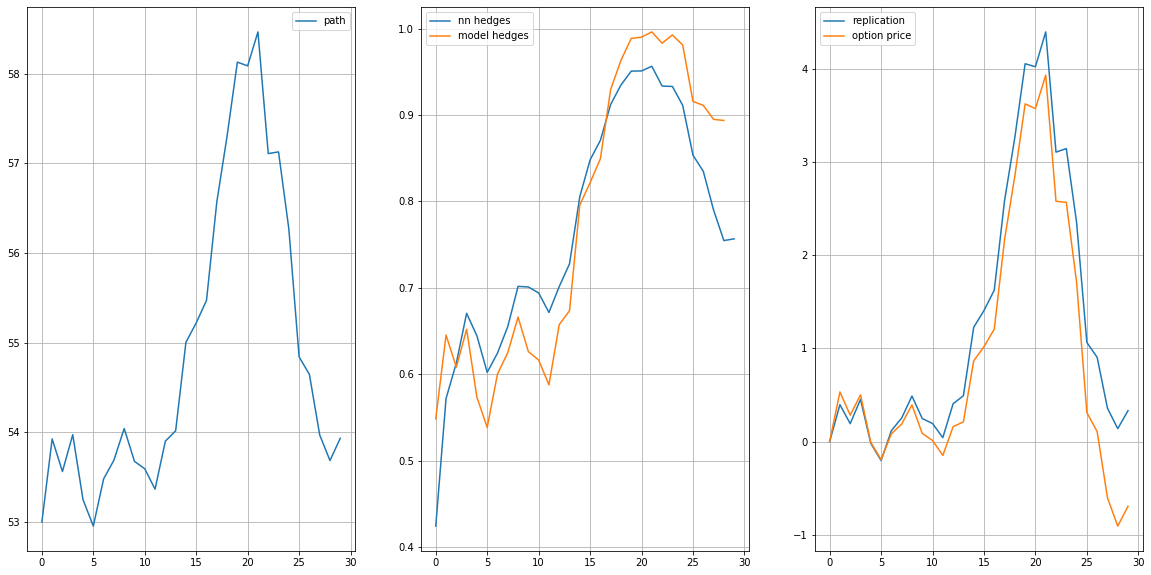

BS price:  1.628
loss:  tf.Tensor(1.3089773284157482, shape=(), dtype=float64)


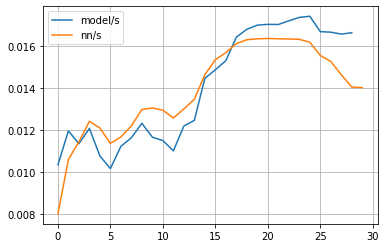

##############################################################################################################


In [29]:
for x, y in test_ds.take(5):
    
    stock = x[0,:,1].numpy()
    bond = x[0,:,0].numpy()
    
    strategy_stock = model.predict(x)[0,:,1]
    strategy_bond = model.predict(x)[0,:,0]
    deltas = delta_BS_option(val_date = time_grid, spot_price = stock)
    
    ptf = stock*strategy_stock+bond*strategy_bond
    
    plt.figure(figsize=[20,10])
    plt.subplot(131)
    
    plt.plot(stock)
    plt.legend(['path'])
    plt.grid(1)
    plt.subplot(132)
    
    plt.plot(strategy_stock,'-')
    plt.plot(deltas,'-')
    plt.legend(['nn hedges','model hedges'])
    plt.grid(1)
    plt.subplot(133)
    
    plt.plot(ptf,'-')
    plt.plot(price_BS_option(val_date = time_grid, spot_price = stock)-price_BS_option(),'-')
    plt.legend(['replication','option price'])
    plt.grid(1)
    plt.show()
    price_BS = price_BS_option()
    print("BS price: ",np.round(price_BS,3))
    print("loss: ", tf.reduce_mean(loss_var(y, model.predict(x))))
    
    plt.figure()
    plt.plot(deltas/stock)
    plt.plot(strategy_stock/stock)
    plt.legend(['model/s','nn/s'])
    plt.grid(1)
    plt.show()
    print("".join(["#"]*110))

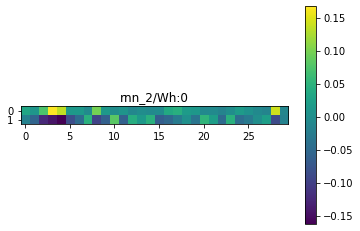

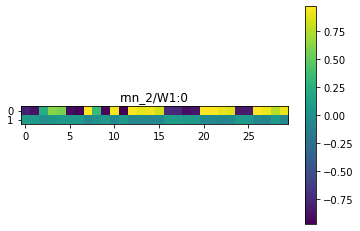

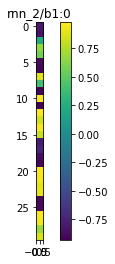

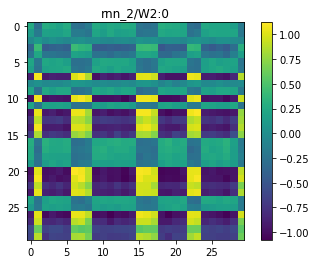

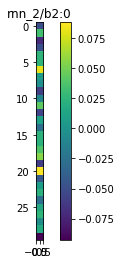

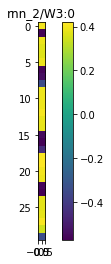

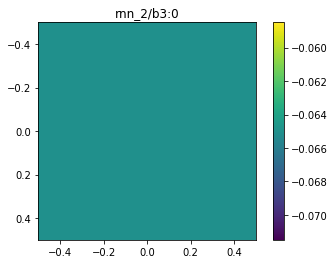

In [30]:
M = [(m.numpy(),m.name) for m in model.weights]

for m in M:
    if len(m[0].shape)==1:
        a = m[0].reshape(-1,1)
    else:
        a = m[0]
    plt.figure()
    plt.title(m[1])
    plt.imshow(a)
    plt.colorbar()
    plt.show()